### Libraries

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from pyDOE import lhs
from torch import tensor
import torch.nn as nn
import scipy.io

### Parameters

In [22]:
torch.set_default_dtype(torch.double)
layer_sizes = [2, 20, 20, 20, 20, 20, 1]
activation = nn.Tanh()
num_epochs = 60000
lr = 1e-3
test_freq = 2000
num_domain = 100   # number of training collocation data points inside the domain
num_data = 2000    # number od data from numerical solution
gpu = 0
device = torch.device('cuda:' + str(gpu) if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

### Burger' s Equation

$$
u_t + u u_x = \frac{0.01}{\pi} u_{xx}
$$

$$
u_t + \lambda_1 u u_x = \lambda_2 u_{xx}
$$

### 


# Data + Visualization

In [23]:
data = scipy.io.loadmat('./burgers_shock.mat') # importing the true data
x = torch.tensor(data['x']).view(-1)                                   
t = torch.tensor(data['t']).view(-1)                                   
usol = torch.tensor(np.real(data['usol']))    

In [24]:
x_grid, t_grid = torch.meshgrid(x, t, indexing = 'ij')  # creating the grid data points from 'x' and 't' data
y_grid = usol  # creating the corresponding grid for the output data

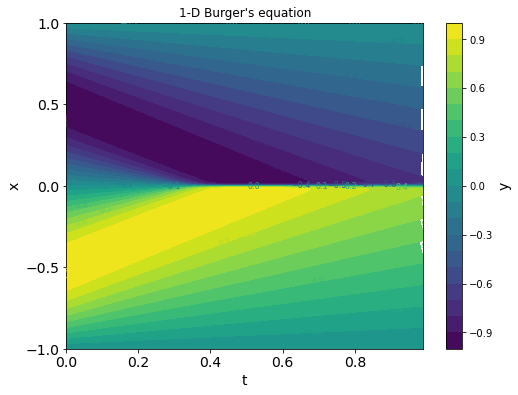

In [25]:
# Create the plot
fig, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(t_grid, x_grid, y_grid, levels=20)
ax.clabel(contour, inline=True, fontsize=8)
ax.tick_params(labelsize=14)
ax.locator_params(axis='x', nbins=5)
ax.locator_params(axis='y', nbins=5)

# Add a title and axis labels
ax.set_title("1-D Burger's equation")
ax.set_xlabel("t", fontsize=14)
ax.set_ylabel("x", fontsize=14)

# Add a color bar
cbar = plt.colorbar(contour)
cbar.set_label("y", fontsize=14)

# Show the plot
plt.show()

# Preparing Data

In [26]:
# reshaping the data for feeding to the model

data_input_all = torch.hstack((x_grid.flatten().view(-1,1), t_grid.flatten().view(-1,1)))
data_output_all = y_grid.flatten().view(-1,1)

In [27]:
lb = data_input_all[0]
ub = data_input_all[-1]

In [28]:
# selecting the desired number of data points from the whole data

idx = np.random.choice(data_input_all.shape[0], size=num_data, replace=False)
x_data = data_input_all[idx, :]
u_data = data_output_all[idx, :]

x_col = lb + (ub-lb) * lhs(x_data.shape[1], num_domain)
x_col = torch.vstack((x_col, x_data))

In [29]:
print(f"{x_data.shape[0]} data points for data loss.")
print(f"{x_col.shape[0]} collocation points inside the domain including boundaries for PDE loss.")

2000 data points for data loss.
2100 collocation points inside the domain including boundaries for PDE loss.


In [30]:
class PhysicsInformedNet(nn.Module):
    
    def __init__(self, layer_sizes, activation=nn.Tanh()):
        super(PhysicsInformedNet, self).__init__()
        
        # defining parameters of the PDE to be identified with their corresponding initial values
        self.lambda_1 = nn.Parameter(torch.tensor([2.]))   
        self.lambda_2 = nn.Parameter(torch.tensor([-5.]))
        
        self.layers = []
        
        for i in range(1, len(layer_sizes)-1):   # defining the neural network
            self.layers.extend([nn.Linear(layer_sizes[i-1], layer_sizes[i]), activation])
            
        self.layers.extend([nn.Linear(layer_sizes[-2], layer_sizes[-1])])
        
        self.net = nn.Sequential(*self.layers)

        # Initialize weights using Xavier initialization and biases to zero
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        
        # Normalization
        
        x = 2.0 * (x - lb)/(ub - lb) - 1.0
        
        return self.net(x)
    

In [31]:
# Define the physics-based model
def PDE(x_col):
    
    x = x_col.clone()
    x.requires_grad = True
    u = model(x)
    lambda_2 = torch.exp(model.lambda_2)
    u_x_u_t = torch.autograd.grad(u, x, grad_outputs = torch.ones(u.shape), create_graph=True)[0] # [0] element inside the tuple
    u_x, u_t = u_x_u_t[:, 0:1], u_x_u_t[:, 1:]
    u_xx_u_tt = torch.autograd.grad(u_x_u_t, x, grad_outputs = torch.ones(u_x_u_t.shape), create_graph=True)[0]
    u_xx = u_xx_u_tt[:, 0:1]
    
    return u_t + model.lambda_1 * u * u_x - lambda_2 * u_xx


# Define the loss function
def loss_func(x_col, x_data, u_data, model):
    u_pred = model(x_data)
    loss_data = F.mse_loss(u_pred, u_data)
    f_pred = PDE(x_col)
    loss_PDE = torch.mean(f_pred**2)
    loss = loss_PDE + loss_data 
    return loss

In [32]:
# creating the model object and the optimizer

model = PhysicsInformedNet(layer_sizes, activation)
optimizer = optim.Adam(model.parameters(), lr=lr)

In [33]:
%%time
Loss_his = []
# Training the PINN
for i in range(num_epochs):
    optimizer.zero_grad()
    loss = loss_func(x_col, x_data, u_data, model)
    loss.backward()
    optimizer.step()
    Loss_his.append(loss.detach().cpu().numpy())
    if i%(test_freq)==0:
        print(f"Loss: {loss.detach().cpu().numpy()}, Parameters: [{model.lambda_1.item()}, {np.exp(model.lambda_2.item())}]")

Loss: 0.514197160095711, Parameters: [1.9990000042329132, 0.0067446820714321815]
Loss: 0.004017671615572467, Parameters: [0.9083590950725399, 0.009560870286185848]
Loss: 0.0013212790311692357, Parameters: [0.9546843858181618, 0.006819313626778907]
Loss: 0.0007428474408682112, Parameters: [0.9753088943137793, 0.005766442730313413]
Loss: 0.0006159203397481554, Parameters: [0.983640207210564, 0.005232611258790822]
Loss: 0.0003958157487889884, Parameters: [0.9872816386082165, 0.00488535661857967]
Loss: 0.0003118849238323096, Parameters: [0.989318316761167, 0.004634856634017337]
Loss: 0.0004862268242093646, Parameters: [0.9910217887887202, 0.004442021913697145]
Loss: 0.00020980691943533547, Parameters: [0.9917562143842976, 0.004291067070390892]
Loss: 0.0001776345637507541, Parameters: [0.9928594408049752, 0.004166203160449305]
Loss: 0.0001533982753920668, Parameters: [0.9935330028358598, 0.0040617081549979]
Loss: 0.00015505120855207892, Parameters: [0.9945503118089635, 0.003971982383936953]

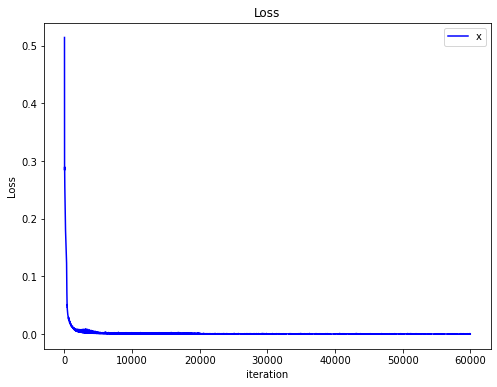

In [34]:
# plotting the Loss over iteration
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(np.array(Loss_his),'b-',label='x',)
plt.xlabel('iteration')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.show()

## Ploting the results
### True solution

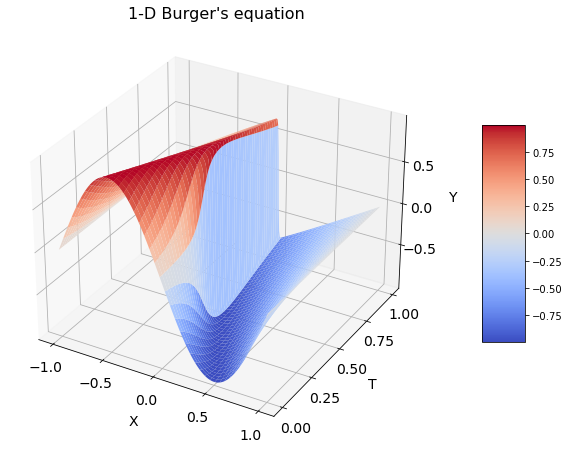

In [35]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(x_grid, t_grid, y_grid, cmap='coolwarm', edgecolor='none')
ax.tick_params(labelsize=14)
ax.locator_params(axis='x', nbins=5)
ax.locator_params(axis='y', nbins=5)
ax.locator_params(axis='z', nbins=6)
fig.colorbar(surf, shrink=0.5, aspect=5, pad=.1)
ax.set_xlabel('X', fontsize=14, labelpad=10)
ax.set_ylabel('T', fontsize=14, labelpad=10)
ax.set_zlabel('Y', fontsize=14, labelpad=10)
ax.set_title("1-D Burger's equation", fontsize=16)

plt.show()

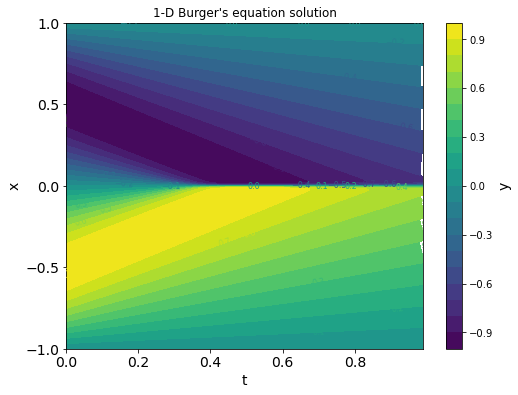

In [37]:
# Create the plot
fig, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(t_grid, x_grid, y_grid, levels=20)
ax.clabel(contour, inline=True, fontsize=8)
ax.tick_params(labelsize=14)
ax.locator_params(axis='x', nbins=5)
ax.locator_params(axis='y', nbins=5)

# Add a title and axis labels
ax.set_title("1-D Burger's equation solution")
ax.set_xlabel("t", fontsize=14)
ax.set_ylabel("x", fontsize=14)

# Add a color bar
cbar = plt.colorbar(contour)
cbar.set_label("y", fontsize=14)

# Show the plot
plt.show()

In [36]:
# using the train model to predict the solution
u_p = model(data_input_all)
u_p = u_p.view(x_grid.shape[0], x_grid.shape[1])

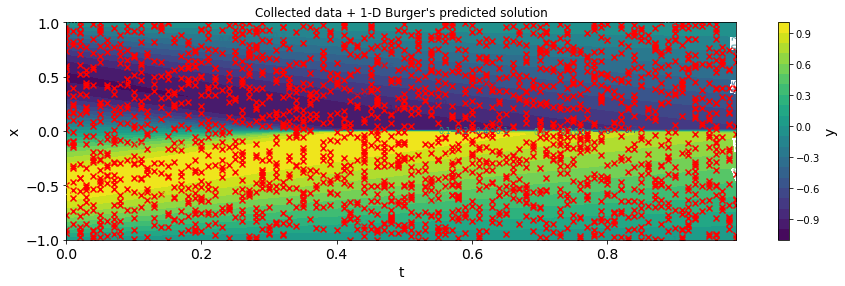

In [39]:
# Create the plot
fig, ax = plt.subplots(figsize=(15, 4))
contour = ax.contourf(t_grid, x_grid, u_p.detach().cpu().numpy(), levels=20)
ax.clabel(contour, inline=True, fontsize=8)
ax.tick_params(labelsize=14)
ax.locator_params(axis='x', nbins=5)
ax.locator_params(axis='y', nbins=5)

ax.scatter(x_data[:,1], x_data[:,0], color='red', marker='x')

# Add a title and axis labels
ax.set_title("Collected data + 1-D Burger's predicted solution")
ax.set_xlabel("t", fontsize=14)
ax.set_ylabel("x", fontsize=14)

# Add a color bar
cbar = plt.colorbar(contour)
cbar.set_label("y", fontsize=14)

# Show the plot
plt.show()

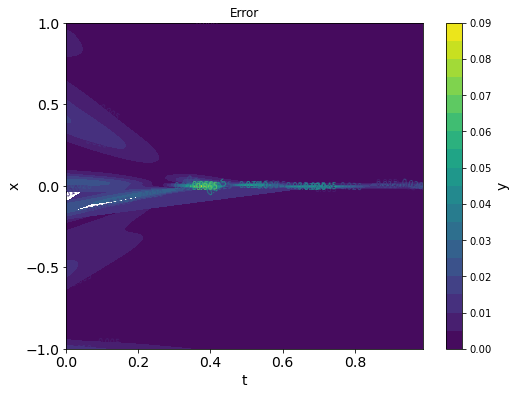

In [40]:
# Create the plot
fig, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(t_grid, x_grid, np.abs(u_p.detach().cpu().numpy()-y_grid.detach().cpu().numpy()), levels=20)
ax.clabel(contour, inline=True, fontsize=8)
ax.tick_params(labelsize=14)
ax.locator_params(axis='x', nbins=5)
ax.locator_params(axis='y', nbins=5)

# Add a title and axis labels
ax.set_title("Error")
ax.set_xlabel("t", fontsize=14)
ax.set_ylabel("x", fontsize=14)

# Add a color bar
cbar = plt.colorbar(contour)
cbar.set_label("y", fontsize=14)

# Show the plot
plt.show()